In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob
import os
import copy
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['axes.grid'] = False

In [2]:
# reading the data into data frames using pandas
"""
data_csv is a list of 10 data frames holding a [2,] list for each symboL
the first one (for example data_csv[i][0] ) is the name of the symbol and
the second one (for example data_csv[i][1] ) is the data assosiated to it
"""
data_csv = []
i = 0
for filename in glob.glob('data/*.csv'):
    data_csv.append([filename[5:len(filename)-4],pd.read_csv(filename).drop("<TICKER>",1)])
    i+=1
# print(data_csv[0][0])
# data_csv[0][1].head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014187133898>],
      dtype=object)

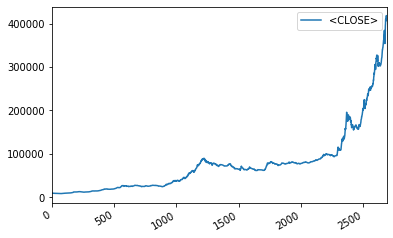

In [3]:
data_frame = 10
features = data_csv[data_frame][1][['<CLOSE>']]
# features.index = data_csv[data_frame][1]['<DTYYYYMMDD>']
# features.head()
features.plot(subplots=True)

In [4]:
def trun_to_windows(input,kernel,future):
    data = []
    labels = []
    for i in range(kernel,len(input)-future):
        data.append(input[i-kernel:i])
        labels.append(input[i:i+future])
    return np.array(data),np.array(labels)

In [17]:
data,labels = trun_to_windows(features.values,20,20)
org_data = data
org_labels = labels
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape((data.shape[:2])))
labels = scaler.fit_transform(labels.reshape((labels.shape[:2])))
data = data.reshape((len(data),20,1))
data.shape,labels.shape

((2651, 20, 1), (2651, 20))

In [6]:
################################################
# from the Models belwo , only one should be run
# the first one , 1 lstm + 1 Dense
# the second one , 2 lstm + 1 Dense
#################################################

In [97]:
model = keras.Sequential()
model.add(keras.layers.LSTM(20, activation='relu', input_shape=data[0].shape))
model.add(keras.layers.Dense(labels.shape[1]))
model.compile(optimizer='adam', loss='mse')
hist = model.fit(data,labels,epochs=20,batch_size=32)

Train on 2651 samples
Epoch 1/20
2651/2651 [==============================] - 5s 2ms/sample - loss: 0.0392
Epoch 2/20
2651/2651 [==============================] - 3s 1ms/sample - loss: 0.0061
Epoch 3/20
2651/2651 [==============================] - 3s 994us/sample - loss: 7.8722e-04
Epoch 4/20
2651/2651 [==============================] - 3s 986us/sample - loss: 3.7937e-04
Epoch 5/20
2651/2651 [==============================] - 3s 1ms/sample - loss: 3.4334e-04
Epoch 6/20
2651/2651 [==============================] - 3s 1ms/sample - loss: 2.8471e-04
Epoch 7/20
2651/2651 [==============================] - 3s 1ms/sample - loss: 2.7645e-04
Epoch 8/20
2651/2651 [==============================] - 3s 1ms/sample - loss: 2.6273e-04
Epoch 9/20
2651/2651 [==============================] - 3s 1ms/sample - loss: 2.6552e-04
Epoch 10/20
2651/2651 [==============================] - 3s 1ms/sample - loss: 2.5267e-04
Epoch 11/20
2651/2651 [==============================] - 4s 1ms/sample - loss: 2.4405e-04
E

In [245]:
model = keras.Sequential()
model.add(keras.layers.LSTM(20, activation='relu',return_sequences = True, input_shape=data[0].shape))
model.add(keras.layers.LSTM(10, activation='relu'))
model.add(keras.layers.Dense(20))
model.compile(optimizer='adam', loss='mae')
hist = model.fit(data,labels,epochs=20,batch_size=32)

Train on 2651 samples
Epoch 1/20
2651/2651 [==============================] - 9s 3ms/sample - loss: 0.1154
Epoch 2/20
2651/2651 [==============================] - 5s 2ms/sample - loss: 0.0313 1s - loss: 0.0 - ET
Epoch 3/20
2651/2651 [==============================] - 5s 2ms/sample - loss: 0.0142
Epoch 4/20
2651/2651 [==============================] - 5s 2ms/sample - loss: 0.0119
Epoch 5/20
2651/2651 [==============================] - 6s 2ms/sample - loss: 0.0111
Epoch 6/20
1984/2651 [=====================>........] - ETA: 1s - loss: 0.0109

KeyboardInterrupt: 

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(20))
model.compile(optimizer='adam', loss='mae')
hist = model.fit(data,labels,epochs=50)

In [236]:
future = []
for i in range(0,len(data),20):
    pred = model.predict(data[i].reshape((1,20,1)))
    future.append(pred)
print(len(future))
future = np.array(future).reshape( (len(future),20) )
future = scaler.inverse_transform(future)
future = np.array(future).reshape( (np.shape(future)[0]*np.shape(future)[1]) )

133


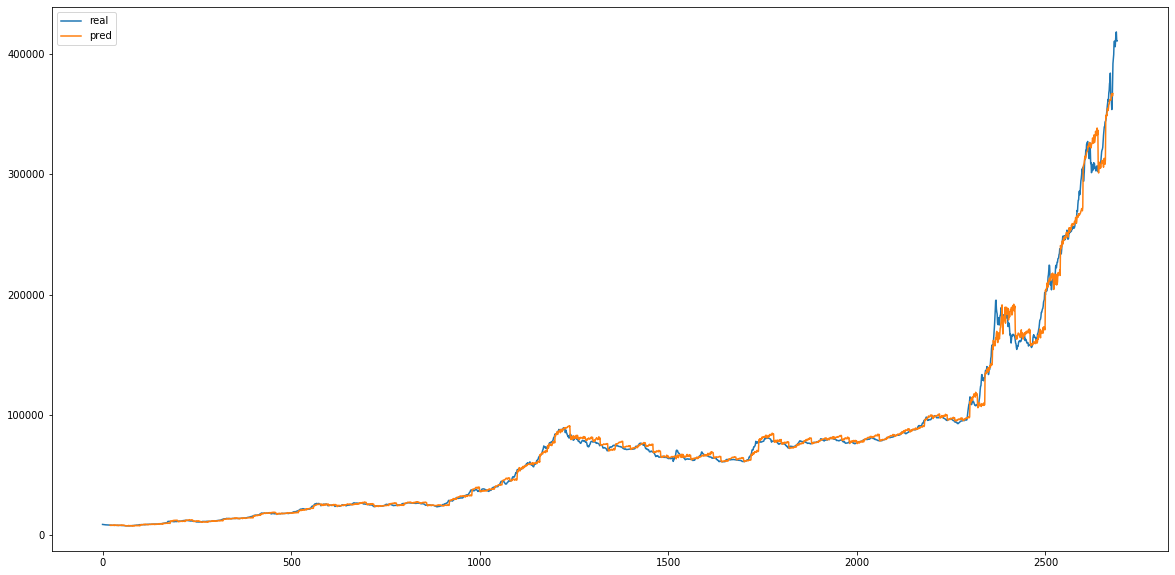

In [237]:
plt.figure(figsize=(20,10))
plt.plot(features.values,label="real")
plt.plot(range(20,len(future)+20),future,label="pred")
plt.legend()

In [238]:
def smooth(input):
    output = []
    output.append(input[0])
    output.append(np.mean([input[0],input[1]]))
    for i in range(2,len(input)-2):
        mean = np.mean([input[i-2],input[i-1],input[i],input[i+1],input[i+2]])
        output.append(mean)
    output.append(np.mean([input[len(input)-2],input[len(input)-1]]))
    output.append(input[len(input)-1])
    return output

      Linear (smooth) : 


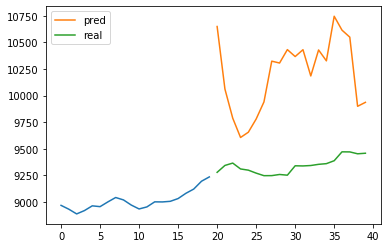

In [246]:
i = 100
pred = model.predict(data[i].reshape(1,20,1))
pred = scaler.inverse_transform(pred)
plt.plot(org_data[i])
plt.plot(range(20,40),smooth(pred.reshape((20))),label="pred")
plt.plot(range(20,40),org_labels[i].reshape( (20) ),label="real")
plt.legend()
print("      Linear (smooth) : ")